# Cafe Location Scouting in Manhattan

For this project we are going to help find the best area in Downtown Manhattan to open a new cafe.  As Manhattan is a pretty saturated market for cafes and is an expensive area to operate in, it is crucial for to gain a deeper understanding of the market we are entering. Using location data from currently successful restaurant operations, we can re cluster Manhattan based on the locations of these high volume restaurants rather than the neighborhoods they fall in, which may give us a different understanding of where people are going out to eat.  
Our goal is to use data and clustering to find a high volume area that is the least saturated with cafes and coffee shops on our list. By positioning the new cafe near other high volume locations, we may be able to capitalize on existing traffic trends. 

To help answer this problem, we will be using a dataset scraped from  [Restaurant Business Online's future 50 restaurants.](https://www.restaurantbusinessonline.com/future-50-2020) and made available via Michal Bogacz on [kaggle](https://www.kaggle.com/michau96/restaurant-business-rankings-2020).  This list includes fifty restaurants that were able to successfully grow their operations during a difficult period in the industry, and were chosen for their ability to adapt and likeliness to continue to excel in the future. The data frame includes the following columns:

Rank = Position in ranking  
Restaurant = Name of restaurant  
Location = Location of origin of the restaurant  
Sales = 2019 Systemwide Sales   	
YOY Sales = Year on year sales increase  	
Stores = Number of premises  	
'YOY Store Growth' = Year on year premises increase 	
Unit_Volume = 2019 Average Unit Volume ($000)   	
Franchising = Is the restaurant a franchise? (Y/N) 
<a id='cleaning'></a>

We will focus on the New York Based companies on this list and group their New York City locations based on coordinates.  We will then cluster these groups and find the average volumes of each zone.  We will see what type of stores appear in which zone, and find which zones could potentially be considered for future cafe locations.  

**Table of Contents**  
1.) [Data Cleaning](#cleaning)    
 2.) [EDA](#EDA)  
 3.) [Clustering](#clustering)  
 4.) [Results](#results) 
 

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
import requests
from pandas.io.json import json_normalize


import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

from sklearn.cluster import KMeans

! pip install folium==0.5.0
import folium
print('Folium Installed!')

     |████████████████████████████████| 79 kB 9.7 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=f507a25af0f771473fd3195d9299daa725c6b45dc1516af6c7248fc5fbc15a2b
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Folium Installed!


In [3]:
df = pd.read_csv(body)
df.head()

,Rank,Restaurant,Location,Sales,YOY_Sales,Units,YOY_Units,Unit_Volume,Franchising
0,1,Evergreens,"Seattle, Wash.",24,130.5%,26,116.7%,1150,No
1,2,Clean Juice,"Charlotte, N.C.",44,121.9%,105,94.4%,560,Yes
2,3,Slapfish,"Huntington Beach, Calif.",21,81.0%,21,90.9%,1370,Yes
3,4,Clean Eatz,"Wilmington, N.C.",25,79.7%,46,58.6%,685,Yes
4,5,Pokeworks,"Irvine, Calif.",49,77.1%,50,56.3%,1210,Yes


In [4]:
df.shape

(50, 9)

In [5]:
df.dtypes

Rank            int64
Restaurant     object
Location       object
Sales           int64
YOY_Sales      object
Units           int64
YOY_Units      object
Unit_Volume     int64
Franchising    object
dtype: object

In [6]:
#changing percents to floats

df['YOY_Sales']=df['YOY_Sales'].apply(lambda x:x.replace('%',''))
df['YOY_Units']=df['YOY_Units'].apply(lambda x:x.replace('%',''))
#===
df['YOY_Sales']= pd.to_numeric(df['YOY_Sales'])
df['YOY_Units']=pd.to_numeric(df['YOY_Units'])

In [7]:
df = df.rename(columns={'Units' : 'Stores','YOY_Units' : 'YOY_Store_Growth'})


# EDA

Let's get an idea for how many locations the restaurants on this list have: 
<a id='EDA'></a>

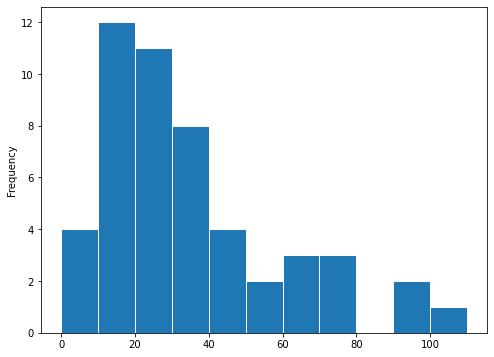

In [8]:
plt.figure(figsize=(8,6))
bins=[0,10,20,30,40,50,60,70,80,90,100,110]
df['Stores'].plot(kind='hist',bins=bins,edgecolor='w')

We can also take a closer look at what cities these stores are based in:

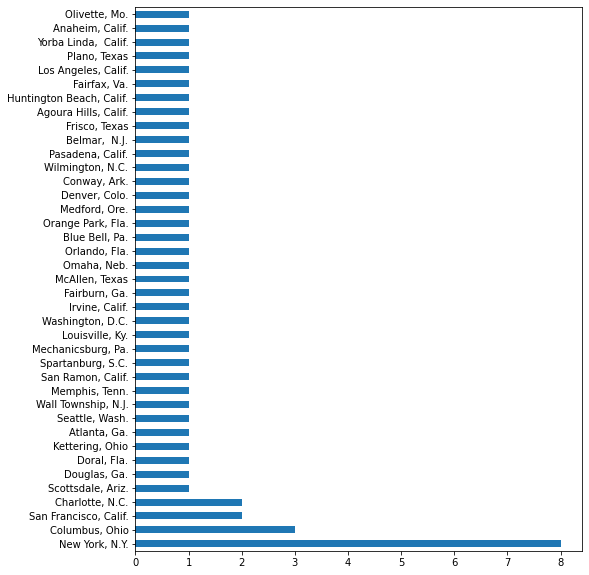

In [9]:
plt.figure(figsize=(8,10))
df['Location'].value_counts().plot(kind='barh')
plt.show()

Let's also take a look at how many of these stores on the list are franchises:

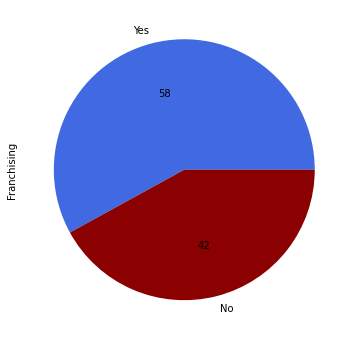

In [10]:
plt.figure(figsize=(6,6))

df['Franchising'].value_counts().plot(kind='pie',autopct='%.f',colors = ['royalblue','darkred'])
plt.show()

we can check and see if franchising has any correlation with the other numbers in our dataframe.

In [11]:
franchise_onehot = pd.get_dummies(df[['Franchising']], prefix="", prefix_sep="")
franchise_onehot = franchise_onehot.rename(columns={'Yes' : 'Franchise?'})
df['Franchise?'] = franchise_onehot['Franchise?']

we'll do the same with NYC locations and see if there is any correlation there as well.  

In [12]:
location_onehot = pd.get_dummies(df[['Location']], prefix="", prefix_sep="")
df['NYC'] = location_onehot['New York, N.Y.']


In [13]:
dfcorr = df[['Sales','YOY_Sales','YOY_Store_Growth','Unit_Volume','Franchise?','NYC','Stores']]

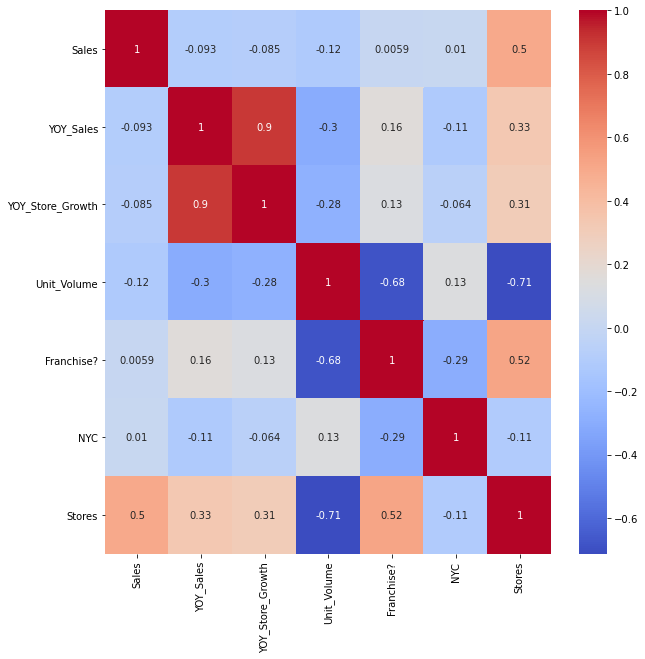

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(dfcorr.corr(), annot=True,cmap='coolwarm')

Nothing too surprising here. From this heatmap, you could say that franchises tend to have slightly more locations and do overall less volume per location.  It is pretty apparent that the more stores you have, the less volume you tend to do at your locations.  We're going to explore volume further and focus our efforts around New York City, where we are planning to open our cafe.   

In [15]:
dfny = df[df.Location=="New York, N.Y."]
dfny = dfny.sort_values('Unit_Volume',ascending=False,ignore_index=True)
dfny

,Rank,Restaurant,Location,Sales,YOY_Sales,Stores,YOY_Store_Growth,Unit_Volume,Franchising,Franchise?,NYC
0,34,Boqueria,"New York, N.Y.",27,22.0,7,16.7,4260,No,0,1
1,25,By Chloe,"New York, N.Y.",37,25.6,14,7.7,2800,No,0,1
2,23,The Little Beet,"New York, N.Y.",23,26.5,12,33.3,2230,No,0,1
3,29,Dos Toros Taqueria,"New York, N.Y.",28,24.0,22,10.0,1375,No,0,1
4,8,Melt Shop,"New York, N.Y.",20,39.6,19,35.7,1260,Yes,1,1
5,32,Just Salad,"New York, N.Y.",42,22.7,38,26.7,1240,No,0,1
6,14,Bluestone Lane,"New York, N.Y.",48,33.0,48,37.1,1175,No,0,1
7,24,Joe & The Juice,"New York, N.Y.",47,25.9,69,25.5,760,Yes,1,1


In [16]:
#drop columns we won't be using
dfny = dfny[['Restaurant','Sales','YOY_Sales','Stores','YOY_Store_Growth','Unit_Volume','Franchise?']]

In [17]:
dfny =dfny.rename(columns={'Restaurant' : 'name'})

Let's incorporate the Foursquare location data and get a feel for where these places are located in New York City.  

*add your Foursquare Credentials here if you are running this notebook*

In [19]:
#Since we have no specified locations yet, we'll plug in the coordinates for New York City, and find locations from there.
NYC_lat = 40.7128
NYC_lng = -74.0060

We'll start by looking at the two shops on our list with the most overall stores, Joe & the Juice and Bluestone Lane.  They coincidentally have the lowest volume per location, but this could also be indicative of the products they are selling and not just store location.

In [20]:
#function from the IBM Coursera Training labs that extracts venue category from JSON file

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [32]:
# Create search function to get url for different searches
def search(x,y):
    search_query = x
    LIMIT = y
    radius = 10000
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
    )
    return url


In [33]:
url = search('Joe & The Juice',70)
url

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Joe & The Juice&radius=10000&limit=70'

In [30]:
results = requests.get(url).json()

In [49]:
#Function to create dataframes from JSON file
def json_to_frame(y):
    venues = y['response']['venues']
    
    x = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['name','categories', 'location.lat', 'location.lng']
    x =x.loc[:, filtered_columns]

    # filter the category for each row
    x['Type'] = x.apply(get_category_type, axis=1)

    # clean columns
    x.columns = [col.split(".")[-1] for col in x.columns]

    return x

In [39]:
joes = json_to_frame(joes,results)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [41]:
joes.shape

(50, 5)

Our search turned up 50 matching items within 10000 Meters of New York City.  
Let's see how many are Joe & the Juice Locations.

In [42]:
joes['name'].value_counts()

JOE & THE JUICE                                                       13
Joe Coffee Company                                                     6
Trader Joe's                                                           4
Joe Coffee                                                             3
Law Office of Joe Stancati                                             2
Tokyo Joe                                                              1
Joe Allen                                                              1
Joe the Art of Coffee                                                  1
Joe Coffee (in Arlo Hudson Square)                                     1
Joe Pro Shop                                                           1
Joe G Ristorante Italiano                                              1
Joe Junior                                                             1
Joe Ginsberg Design                                                    1
Joe & Pat's Pizzeria and Restaurant                

We got 13 true matches.  We'll drop the other stores on our list and focus only on the Joe & the Juice locations.

In [43]:
JustJoes = joes[joes['name'].str.contains("JOE & THE JUICE")]
JustJoes = JustJoes[['name','lat','lng','Type']]
JustJoes

,name,lat,lng,Type
0,JOE & THE JUICE,40.715674,-74.010960,Juice Bar
1,JOE & THE JUICE,40.722482,-73.997453,Juice Bar
2,JOE & THE JUICE,40.712777,-74.013345,Juice Bar
3,JOE & THE JUICE,40.705570,-74.008160,Juice Bar
4,JOE & THE JUICE,40.705941,-74.011644,Juice Bar
6,JOE & THE JUICE,40.725983,-74.001298,Juice Bar
17,JOE & THE JUICE,40.762738,-73.977966,Juice Bar
20,JOE & THE JUICE,40.765877,-73.981975,Juice Bar
26,JOE & THE JUICE,40.754717,-73.982774,Juice Bar
32,JOE & THE JUICE,40.770128,-73.962422,Juice Bar


I'll rename the stores so they match our other dataframe.

In [44]:
JustJoes['name'] = JustJoes['name'].str.replace('JOE & THE JUICE','Joe & The Juice')


Now let's do the same for Bluestone Lane.

In [45]:
url2 = search('Bluestone Lane',50)
url2

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Bluestone Lane&radius=10000&limit=50'

In [46]:
results2 = requests.get(url2).json()

In [50]:
bluestone = json_to_frame(results2)
bluestone.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,Type
0,Bluestone Lane,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.706268,-74.011687,Café
1,Bluestone Lane,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.700880,-73.988060,Café
2,Bluestone Lane,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.730009,-74.002855,Café
3,Bluestone Lane,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",40.730104,-73.990307,Coffee Shop
4,Bluestone Lane Collective Cafe,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.735808,-74.000863,Café


In [51]:
bluestone.shape

(50, 5)

In [52]:
bluestone['name'].value_counts()

Bluestone Lane                    20
Maiden Lane Medical                2
11 Maiden Lane                     1
Bluestone Lane Collective Cafe     1
Maiden Lane Wines & Liquors        1
Brick Lane Curry House             1
Andrew Lavoott Bluestone           1
Butter Lane                        1
Brouwerij Lane                     1
Petticoat Lane                     1
Lane Cafe                          1
100 Maiden Lane Sundeck            1
Bluestone Lane Cafe                1
16 Maiden Lane                     1
Bluestone Lane Coffee              1
Lane Jewelers                      1
Bluestone Café                     1
Xpress Lane Pharmacy               1
180 Maiden Lane                    1
Minetta Lane Theatre               1
6 Maiden Lane                      1
Dutch Lane Walk of Shame           1
Cherry Lane Theatre                1
80 Maiden Lane                     1
Bluestone                          1
59 Maiden Lane                     1
100 Maiden Lane GYM                1
3

In [53]:
bluestone = bluestone[bluestone['name'].str.contains("Bluestone Lane")]
bluestone['name'] = bluestone['name'].str.replace('Bluestone Lane Coffee','Bluestone Lane')
bluestone['name'] = bluestone['name'].str.replace('Bluestone Lane Collective Cafe','Bluestone Lane')
bluestone['name'] = bluestone['name'].str.replace('Bluestone Lane Cafe ','Bluestone Lane')


In [54]:
bluestone = bluestone[['name','lat','lng','Type']]

Let's view how these cafes are spread out across manhattan.

In [55]:
cafe_map = folium.Map(location=[NYC_lat, NYC_lng], zoom_start=12)

for lat, lng, label in zip(bluestone.lat, bluestone.lng, bluestone.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='grey',
        popup=label,
        fill = True,
        fill_color='dodgerblue',
        fill_opacity=0.6
    ).add_to(cafe_map)
    

for lat, lng, label in zip(JustJoes.lat, JustJoes.lng, JustJoes.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        popup=label,
        fill = True,
        fill_color='deeppink',
        fill_opacity=0.6
    ).add_to(cafe_map)
    
    
cafe_map

Next, let's get info for the rest of the list.

In [56]:
url3 = search('Boqueria',10) #There are 7 locations in existence according to the dataframe, so this should cover NYC locations with some room.
url3

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Boqueria&radius=10000&limit=10'

In [57]:
results3 = requests.get(url3).json()

In [58]:
boqueria = json_to_frame(results3)
boqueria.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,Type
0,Boqueria,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",40.724800,-74.002220,Tapas Restaurant
1,Boqueria,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",40.740200,-73.993770,Tapas Restaurant
2,Boqueria,"[{'id': '4bf58dd8d48988d150941735', 'name': 'S...",40.771510,-73.956073,Spanish Restaurant
3,Boqueria,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",40.755582,-73.990337,Tapas Restaurant


In [59]:
boqueria.shape

(4, 5)

In [60]:
boqueria = boqueria[['name','lat','lng','Type']]

In [61]:
url4 = search('By Chloe',20) #There are 14 locations in existence according to the dataframe, so this should cover NYC locations with some room.
url4

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=By Chloe&radius=10000&limit=20'

In [62]:
results4 = requests.get(url4).json()

In [63]:
chloe = json_to_frame(results4)
chloe.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,Type
0,By Chloe.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.706532,-74.004134,Vegetarian / Vegan Restaurant
1,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.722770,-73.997200,Vegetarian / Vegan Restaurant
2,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.715214,-73.959363,Vegetarian / Vegan Restaurant
3,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.736640,-73.991220,Vegetarian / Vegan Restaurant
4,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.758063,-73.978854,Vegetarian / Vegan Restaurant


In [64]:
chloe = chloe[['name','lat','lng','Type']]
chloe.name.value_counts()

by CHLOE.                                        5
By Chloe.                                        2
CUT by Wolfgang Puck                             1
New York by Gehry                                1
Courtyard by Marriott New York Manhattan/SoHo    1
Courtyard by Marriott                            1
New York by Gehry Game Room                      1
Sweets by CHLOE.                                 1
New York By Gehry Pool                           1
Green Apple Cleaners @ New York by Gehry         1
DoubleTree by Hilton                             1
Thrills By CHLOE.                                1
Chloe 81                                         1
New York by Gehry Courtyard                      1
by. CHLOE                                        1
Name: name, dtype: int64

In [65]:
chloe['name'] = chloe['name'].str.replace('Sweets by CHLOE.','By Chloe')
chloe['name'] = chloe['name'].str.replace('by CHLOE.','By Chloe')
chloe['name'] = chloe['name'].str.replace('By Chloe.','By Chloe')
chloe['name'] = chloe['name'].str.replace('by. CHLOE','By Chloe')

chloe = chloe[chloe['name'].str.contains("By Chloe")]
chloe

,name,lat,lng,Type
0,By Chloe,40.706532,-74.004134,Vegetarian / Vegan Restaurant
1,By Chloe,40.722770,-73.997200,Vegetarian / Vegan Restaurant
2,By Chloe,40.715214,-73.959363,Vegetarian / Vegan Restaurant
3,By Chloe,40.736640,-73.991220,Vegetarian / Vegan Restaurant
4,By Chloe,40.758063,-73.978854,Vegetarian / Vegan Restaurant
5,By Chloe,40.741862,-73.992998,Vegetarian / Vegan Restaurant
6,By Chloe,40.753019,-73.987703,Vegetarian / Vegan Restaurant
8,By Chloe,40.729262,-74.000920,Bakery
9,By Chloe,40.759154,-73.971021,Vegetarian / Vegan Restaurant


In [66]:
url5 = search('The Little Beet',15) #There are 12 locations in existence according to the dataframe, so this should cover NYC locations with some room.
url5

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=The Little Beet&radius=10000&limit=15'

In [67]:
results5 = requests.get(url5).json()

In [68]:
beet = json_to_frame(results5)
beet.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,Type
0,The Little Beet Table,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.741086,-73.985333,Restaurant
1,The Little Beet,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.726851,-74.037911,Restaurant
2,The Little Beet,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.744036,-73.988810,Vegetarian / Vegan Restaurant
3,The Little Beet,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.760870,-73.982480,Restaurant
4,The Little Beet,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.757786,-73.974309,Restaurant


In [69]:
beet = beet[['name','lat','lng','Type']]
beet.name.value_counts()

The Little Beet                       7
The Little One NYC                    1
The Little Gym of Tribeca             1
The Little Sandwich Shop              1
The Little Place                      1
The Little Beet Table                 1
The Little Shop                       1
The Little Owl                        1
The Little Black Jacket Exhibition    1
Name: name, dtype: int64

In [70]:
beet = beet[beet['name'].str.contains("The Little Beet")]
beet['name'] = beet['name'].str.replace('The Little Beet Table','The Little Beet')
beet

,name,lat,lng,Type
0,The Little Beet,40.741086,-73.985333,Restaurant
1,The Little Beet,40.726851,-74.037911,Restaurant
2,The Little Beet,40.744036,-73.988810,Vegetarian / Vegan Restaurant
3,The Little Beet,40.760870,-73.982480,Restaurant
4,The Little Beet,40.757786,-73.974309,Restaurant
5,The Little Beet,40.751498,-73.977821,Vegetarian / Vegan Restaurant
6,The Little Beet,40.705075,-74.009160,Restaurant
8,The Little Beet,40.753955,-73.985541,Restaurant


In [71]:
url6 = search('Dos Toros Taqueria',25) #There are 22 locations in existence according to the dataframe, so this should cover NYC locations with some room.
url6

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Dos Toros Taqueria&radius=10000&limit=25'

In [72]:
results6 = requests.get(url6).json()

In [73]:
toros = json_to_frame(results6)
toros.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,Type
0,Dos Toros Taquería,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",40.713058,-74.015980,Burrito Place
1,Dos Toros Taqueria,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",40.706892,-74.006850,Burrito Place
2,Dos Toros Taqueria,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",40.730347,-74.002196,Burrito Place
3,Dos Toros Taquería,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",40.733699,-73.989639,Mexican Restaurant
4,Dos Toros Taqueria,"[{'id': '4bf58dd8d48988d153941735', 'name': 'B...",40.741482,-73.993792,Burrito Place


In [74]:
toros = toros[['name','lat','lng','Type']]
toros.name.value_counts()

Dos Toros Taqueria    11
Dos Toros Taquería     5
Dos Toros              2
Dos Toros HQ           1
Name: name, dtype: int64

In [75]:
url7 = search('Melt Shop',20) #There are 19 locations in existence according to the dataframe, so this should cover NYC locations with some room.
url7

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Melt Shop&radius=10000&limit=20'

In [76]:
results7 = requests.get(url7).json()

In [77]:
melt = json_to_frame(results7)
melt.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,Type
0,Melt Shop,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",40.709895,-74.006564,Sandwich Place
1,Melt Shop,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.726925,-74.038352,Restaurant
2,Melt Shop,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",40.744678,-73.990847,Sandwich Place
3,Melt Shop,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",40.763896,-73.985298,Sandwich Place
4,Melt Shop,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",40.760954,-73.982130,Sandwich Place


In [78]:
melt = melt[['name','lat','lng','Type']]
melt.name.value_counts()

Melt Shop                                   5
Iron Valley Harley Davidson Shop            1
Ray's Barber Shop                           1
Kam Hing Coffee Shop 金興                     1
Lux Accessories @ Shop Small Pop-Up Mall    1
Hong Kong Barber Shop                       1
Mary's Coffee Shop                          1
Dante Coffee Shop                           1
Melt Ice Cream Sandwiches                   1
The Magic Costume Shop                      1
Dazhong Barber Shop                         1
J.Crew Men's Shop                           1
The Men's Shop, Club Monaco                 1
Melt Bakery                                 1
Smoke Shop                                  1
The Face Shop                               1
Name: name, dtype: int64

In [79]:
melt = melt[melt['name'].str.contains("Melt Shop")]

In [80]:
url8 = search('Just Salad',40) #There are 38 locations in existence according to the dataframe, so this should cover NYC locations with some room.
url8

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Just Salad&radius=10000&limit=40'

In [81]:
results8 = requests.get(url8).json()

In [82]:
salad = json_to_frame(results8)
salad.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,Type
0,Just Salad,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",40.707042,-74.007174,Salad Place
1,Just Salad,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",40.703539,-74.011627,Salad Place
2,Just Salad,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",40.712219,-74.014414,Salad Place
3,Just Salad,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",40.712713,-74.008202,Salad Place
4,Just Salad,"[{'id': '4bf58dd8d48988d1bd941735', 'name': 'S...",40.746318,-73.994003,Salad Place


In [83]:
salad = salad[['name','lat','lng','Type']]
salad.name.value_counts()

Just Salad                                  24
Just Salad Goldman sachs cafeteria           1
Just Shades                                  1
Just Salad HQ                                1
Just Scandinavian                            1
Just Us League                               1
just phở                                     1
Just Desserts                                1
Pine Street Smoothies & Fruit Salad Cart     1
Just Jenn Productions                        1
Just Ageless                                 1
Joe's Salad Bar                              1
Salad Box NY                                 1
Just Bifocals                                1
Just men                                     1
Just Yogurt Truck                            1
Just Cavalli Showroom                        1
Name: name, dtype: int64

In [84]:
salad = salad[salad['name'].str.contains("Just Salad")]
salad.name.value_counts()

Just Salad                            24
Just Salad Goldman sachs cafeteria     1
Just Salad HQ                          1
Name: name, dtype: int64

In [85]:
#concatenate our store dataframes
stores = pd.concat([beet, boqueria, chloe, bluestone, JustJoes, salad, melt, toros], axis=0)


## Clustering the stores into zones
<a id='clustering'></a>

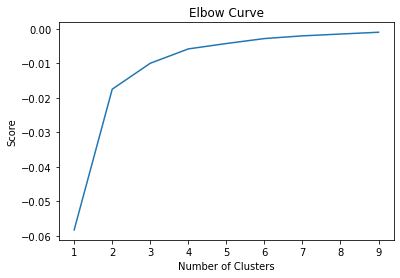

In [86]:
#elbow curve 
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = stores[['lat']]
X_axis = stores[['lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]


# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [87]:
kclusters = 4

In [88]:
kmeans = KMeans(n_clusters =kclusters, init ='k-means++')
kmeans.fit(stores[stores.columns[1:3]]) 
stores['cluster_label'] = kmeans.fit_predict(stores[stores.columns[1:3]])
centers = kmeans.cluster_centers_ 
labels = kmeans.predict(stores[stores.columns[1:3]])
stores.head(10)

,name,lat,lng,Type,cluster_label
0,The Little Beet,40.741086,-73.985333,Restaurant,1
1,The Little Beet,40.726851,-74.037911,Restaurant,2
2,The Little Beet,40.744036,-73.988810,Vegetarian / Vegan Restaurant,1
3,The Little Beet,40.760870,-73.982480,Restaurant,3
4,The Little Beet,40.757786,-73.974309,Restaurant,3
5,The Little Beet,40.751498,-73.977821,Vegetarian / Vegan Restaurant,3
6,The Little Beet,40.705075,-74.009160,Restaurant,2
8,The Little Beet,40.753955,-73.985541,Restaurant,3
0,Boqueria,40.724800,-74.002220,Tapas Restaurant,1
1,Boqueria,40.740200,-73.993770,Tapas Restaurant,1


Let's visualize the clusters on a map and see what types of stores make up each cluster.

In [90]:
cluster_map = folium.Map(location=[NYC_lat, NYC_lng], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stores['lat'], stores['lng'], stores['Type'], stores['cluster_label']):
    label = folium.Popup(str(poi) + '-Zone ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
       
cluster_map

Now we can further analyze these clusters and see if there are any similarities between the numbers and which type of stores populate which areas.



In [91]:
# merge sales data to our cluster dataframe
merged = pd.merge(
    stores,
    dfny,
    how="inner",
    on=None,
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [92]:
merged.head(10)

,name,lat,lng,Type,cluster_label,Sales,YOY_Sales,Stores,YOY_Store_Growth,Unit_Volume,Franchise?
0,Bluestone Lane,40.706268,-74.011687,Café,2,48,33.0,48,37.1,1175,0
1,Bluestone Lane,40.700880,-73.988060,Café,2,48,33.0,48,37.1,1175,0
2,Bluestone Lane,40.730009,-74.002855,Café,1,48,33.0,48,37.1,1175,0
3,Bluestone Lane,40.730104,-73.990307,Coffee Shop,1,48,33.0,48,37.1,1175,0
4,Bluestone Lane,40.735808,-74.000863,Café,1,48,33.0,48,37.1,1175,0
5,Bluestone Lane,40.704599,-74.008748,Café,2,48,33.0,48,37.1,1175,0
6,Bluestone Lane,40.713360,-74.034026,Café,2,48,33.0,48,37.1,1175,0
7,Bluestone Lane,40.783757,-73.958526,Café,0,48,33.0,48,37.1,1175,0
8,Bluestone Lane,40.721860,-73.995703,Café,1,48,33.0,48,37.1,1175,0
9,Bluestone Lane,40.755470,-73.983178,Coffee Shop,3,48,33.0,48,37.1,1175,0


In [102]:
#abbreviating this for graphing purposes
merged['Type'] = merged['Type'].str.replace('Vegetarian / Vegan Restaurant','Veg Restaurant')


# Results <a id='results'></a>

In [103]:
merged['cluster_label'].value_counts()

3    38
1    27
2    21
0    10
Name: cluster_label, dtype: int64

In [104]:
cluster_zero =  merged[merged['cluster_label']==0]
cluster_one =  merged[merged['cluster_label']==1]
cluster_two =  merged[merged['cluster_label']==2]
cluster_three =  merged[merged['cluster_label']==3]

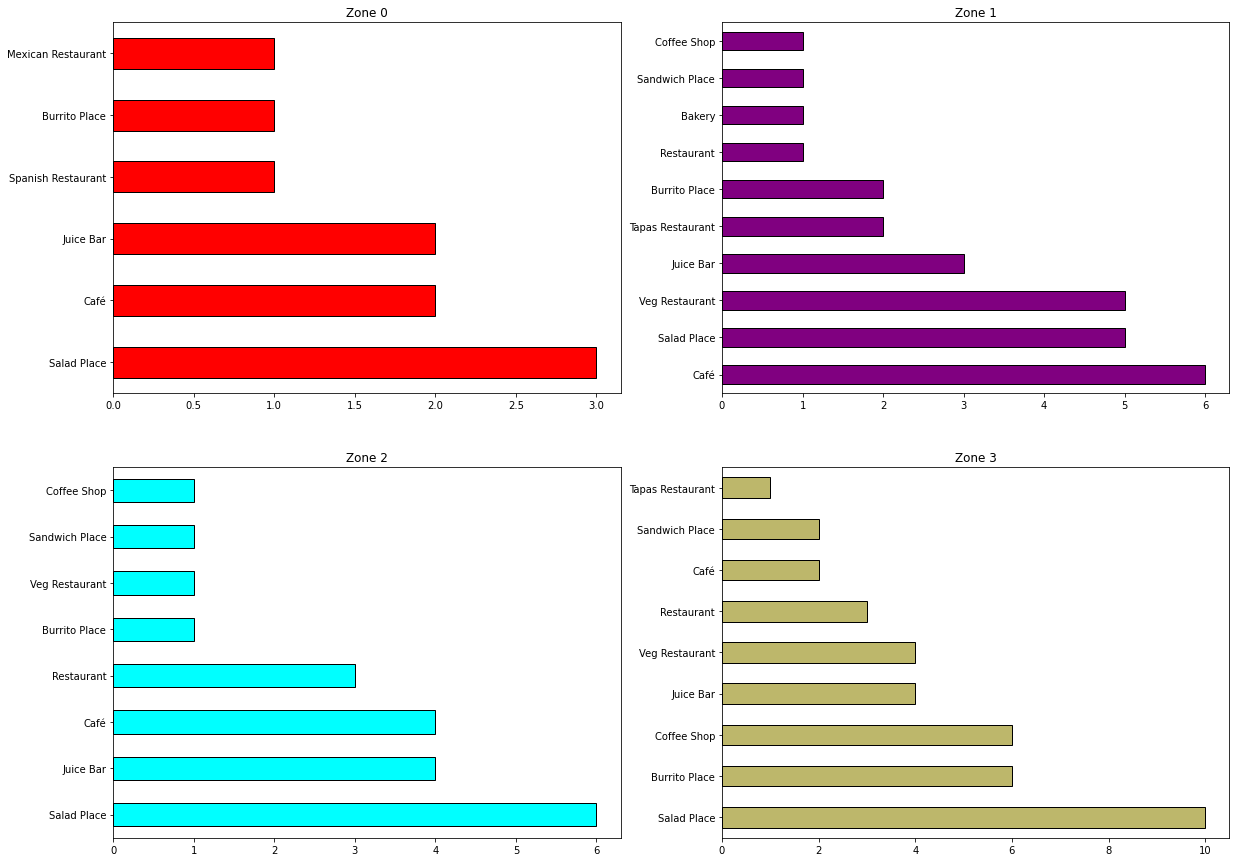

In [107]:
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
cluster_zero['Type'].value_counts().plot(kind='barh',color = 'red',edgecolor='black')
plt.title('Zone 0')

plt.subplot(2,2,2)
cluster_one['Type'].value_counts().plot(kind='barh',color = 'purple',edgecolor='black')
plt.title('Zone 1')

plt.subplot(2,2,3)
cluster_two['Type'].value_counts().plot(kind='barh',color = 'cyan',edgecolor='black')
plt.title('Zone 2')

plt.subplot(2,2,4)
cluster_three['Type'].value_counts().plot(kind='barh',color = 'darkkhaki',edgecolor='black')
plt.title('Zone 3')


plt.show()




# Average Unit Volume Per Zone

In [111]:
zero_mean = cluster_zero['Unit_Volume'].mean()
one_mean = cluster_one['Unit_Volume'].mean()
two_mean = cluster_two['Unit_Volume'].mean()
three_mean = cluster_three['Unit_Volume'].mean()

print('The average unit volume for zone 0 is :')
print(zero_mean)
print('----------')
print('The average unit volume for zone 1 is :')
print(one_mean)
print('----------')
print('The average unit volume for zone 2 is :')
print(two_mean)
print('----------')
print('The average unit volume for zone 3 is :')
print(three_mean)


The average unit volume for zone 0 is :
1460.0
----------
The average unit volume for zone 1 is :
1766.4814814814815
----------
The average unit volume for zone 2 is :
1310.0
----------
The average unit volume for zone 3 is :
1505.0


### Which zone is best for our new cafe?

From this data we would likely consider Zone 0, which has significant volume and less cafes and coffee shops when compared to the other zones.  We could also consider looking more closely into zone 1 which has the highest average volume, however it holds the second most cafes and coffee shops.   